In [2]:
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Plot y_true vs cross-validated predictions of baseline models 

In [3]:
dataset = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']) \
  .sort_values('reportts')

dataset = dataset[dataset['pos'] == 1]

y = dataset['egtm']

X = dataset.drop(columns=[
    'acnum', 'pos', 'dep', 'arr', 
    'egtm', 'fltdes', 'reportts',
    'dmusw', 'exswpn', 'reason'
]).fillna(0)

X = X.loc[:, ~X.columns.str.contains('stw')]

In [5]:
def plot_predict(y, preds, name=f"EGTM true vs predicted on engine 1"):
    rmse = mean_squared_error(y, preds, squared=False)
    mae = mean_absolute_error(y, preds)
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    ax.plot(dataset['reportts'], y, '-')
    ax.plot(dataset['reportts'], preds, '-')
    ax.legend(['True', 'Prediction'])
    ax.set_title(f"{name}\nrmse={rmse:.5f}\nmae={mae:.5f}")
    plt.show()
    

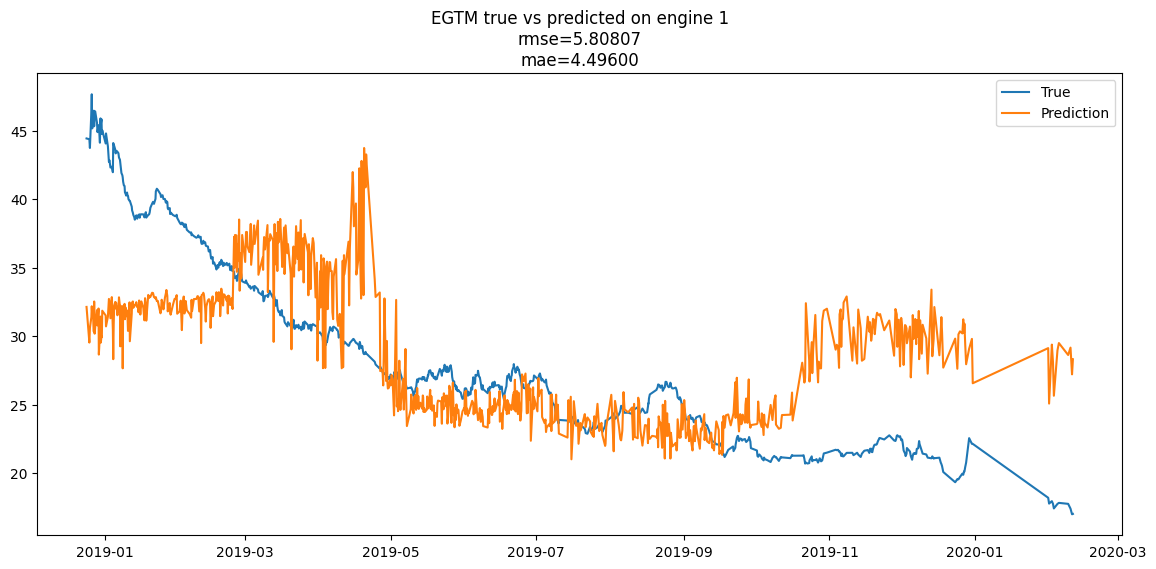

In [128]:
model = CatBoostRegressor(verbose=False, n_estimators=10, random_state=42)
preds = cross_val_predict(model, X, y)
plot_predict(y, preds)

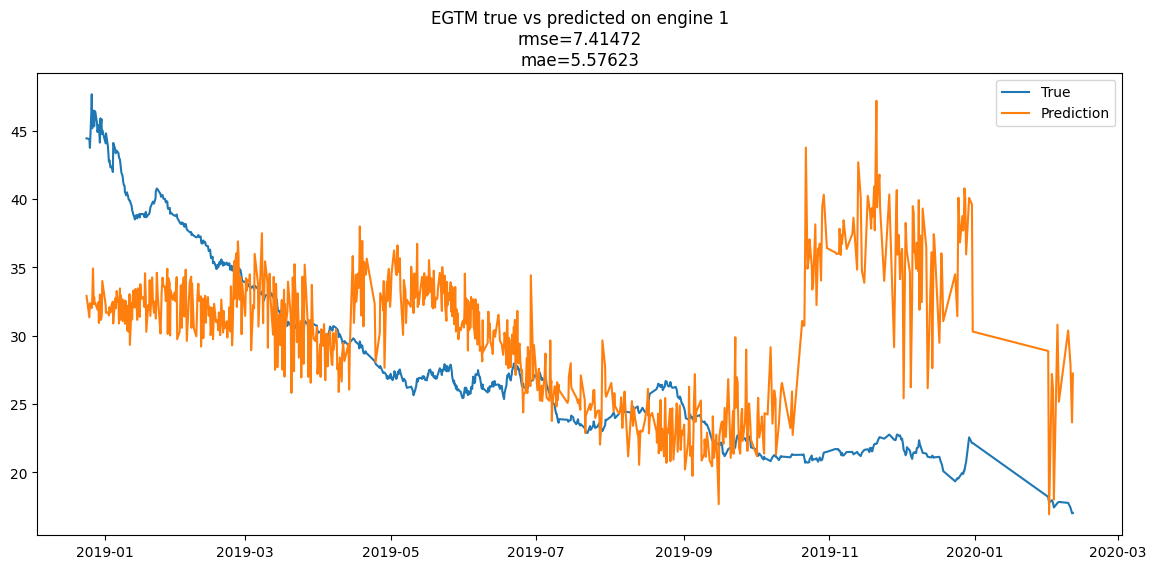

In [129]:
model = Ridge(solver='lsqr', fit_intercept=True, random_state=42)
preds = cross_val_predict(model, X, y)
plot_predict(y, preds)

In [193]:
important_features = ['naiup', 'ecyc', 'oat', 'fdp', 'ehrs', 'tec', 't2', 'egt', 'egt_peak', 'tat', 'tat_peak']

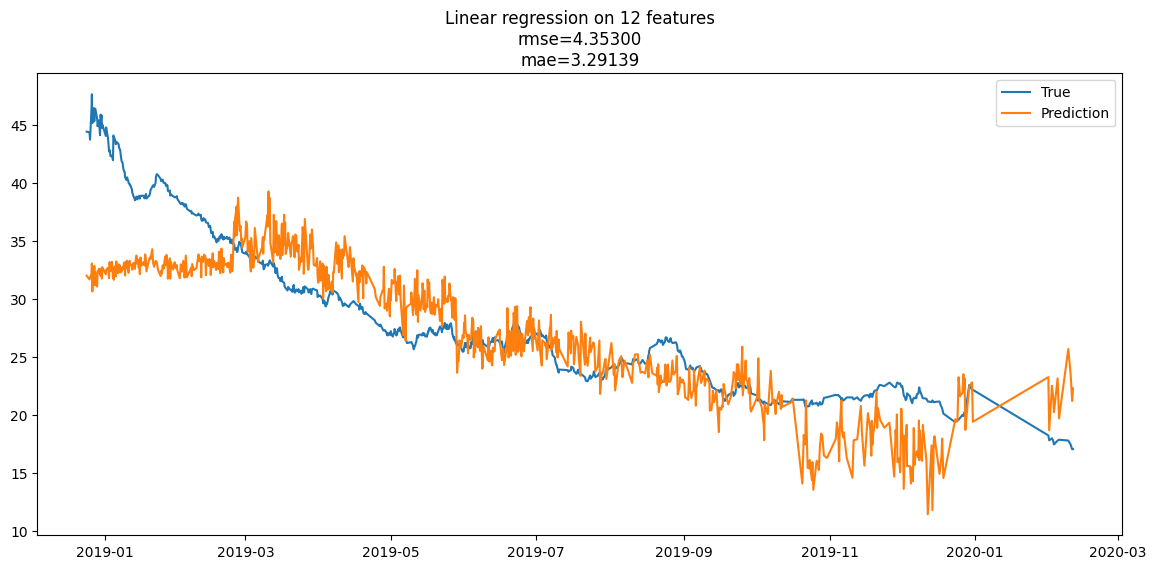

In [210]:
model = LinearRegression(fit_intercept=True)
preds = cross_val_predict(model, X[important_features], y)
plot_predict(y, preds, f"Linear regression on {len(important_features)} features")

### Generate features and measure impact

In [197]:
base_rmse = 4.38957
impacts = []

for feature in important_features:
    model = LinearRegression(fit_intercept=True)
    X_aug = X[important_features].copy()
    X_aug[f'{feature}_2'] = X[feature] ** 2
    preds = cross_val_predict(model, X_aug, y)
    rmse = mean_squared_error(y, preds, squared=False)
    impacts.append((feature, base_rmse - rmse))

impacts

[('egt', 0.07026855138486532),
 ('naiup', 0.5138228208387168),
 ('nait', 0.07667704566600708),
 ('tec', 0.07775491216769659),
 ('aoc', 0.03878510613336683),
 ('ecyc', -0.12701002000168948),
 ('esn', 0.03657493618430685),
 ('ehrs', -0.16373376299714426),
 ('fdp', 0.3903127392098731),
 ('ps14', -11.197093501684282),
 ('w14', 0.01813334673308642),
 ('egtb', 0.02112908946526204)]

In [198]:
impacts = []

for feature in ['naiup', 'fdp', 'egt', 'egt_peak']:
    print(feature)
    model = LinearRegression(fit_intercept=True)
    X_aug = X[important_features].copy()
    X_aug[f'{feature}_log'] = np.log(X[feature])
    preds = cross_val_predict(model, X_aug, y)
    rmse = mean_squared_error(y, preds, squared=False)
    impacts.append((feature, base_rmse - rmse))

impacts

naiup
fdp
egt
egt_peak


[('naiup', 0.4786995399869727),
 ('fdp', 0.4167570130231786),
 ('egt', 0.06970980617838674),
 ('egt_peak', 0.018252512421290668)]

In [205]:
important_features = [
 'egt', 'naiup', 'nait', 'tec', 'aoc', 'ecyc', 'esn', 'ehrs', 'fdp', 'ps14', 'w14', 'egtb'
]

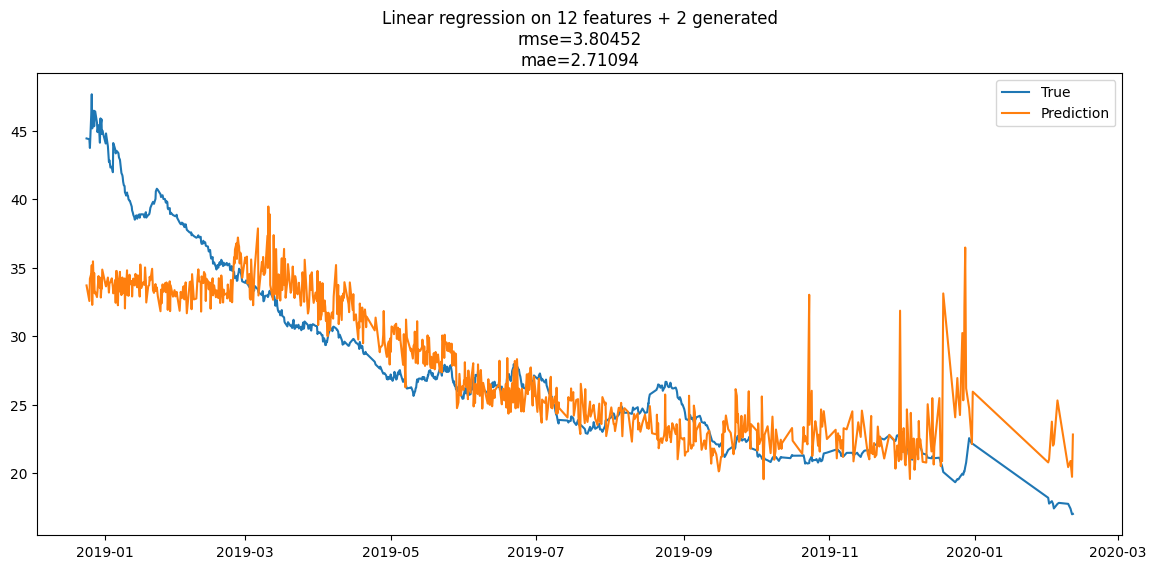

In [211]:
model = LinearRegression(fit_intercept=True)
XX = X[important_features].copy()
XX['fdp_2'] = X['fdp'] ** 2
XX['naiup_2'] = X['naiup'] ** 2
XX.drop(columns=['fdp', 'naiup'])
preds = cross_val_predict(model, XX, y)
plot_predict(y, preds, f"Linear regression on {len(important_features)} features + 2 generated")

In [200]:
important_features = [
 'egt', 'naiup', 'nait', 'tec', 'aoc', 'ecyc', 'esn', 'ehrs', 'fdp', 'ps14', 'w14', 'egtb'
]

### Try to start from 2-3 features and add more important features
Determine important features progressfully based on their impact on linreg

In [36]:
curr_important = ['naiup', 'fmvc', 'baf', 'fdp', 'aoc', 'oip', 'alt', 'ttp', 'bbv']

x = X[curr_important]
model = LinearRegression(n_jobs=-1)
preds = cross_val_predict(model, x, y)
base_rmse = mean_squared_error(y, preds, squared=False)
base_mae = mean_absolute_error(y, preds)

max_impact = -1000
next_feature = None

features = X.columns
for feature in features:
    if feature in curr_important:
        continue
    x_aug = x.copy()
    x_aug[feature] = X[feature]
    model = LinearRegression(n_jobs=-1)
    preds = cross_val_predict(model, x_aug, y)
    rmse = mean_squared_error(y, preds, squared=False)
    mae = mean_absolute_error(y, preds)

    if base_rmse - rmse >= max_impact:
        max_impact = base_rmse - rmse
        next_feature = feature

next_feature, max_impact

('sva', 0.03419265254254622)

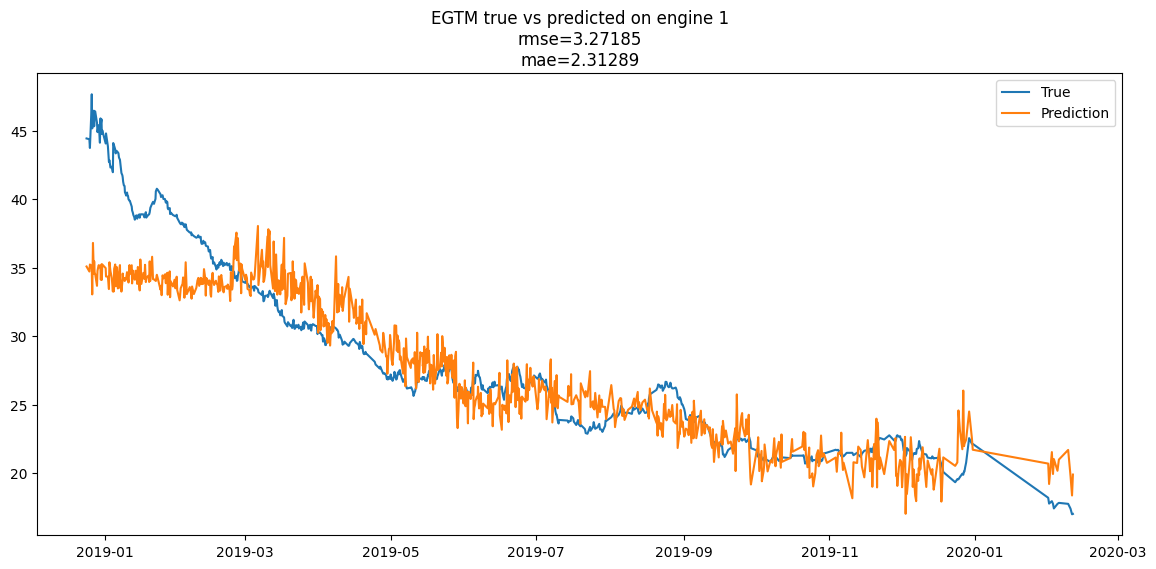

In [48]:
important_features = ['naiup', 'fmvc', 'baf', 'fdp', 'aoc', 'oip', 'alt', 'ttp', 'bbv']
model = LinearRegression()
x2 = X[important_features].copy()
x2['fdp_2'] = x2['fdp'] ** 2
preds = cross_val_predict(model, x2, y)
plot_predict(y, preds)